The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
No GPU available, using the CPU instead.


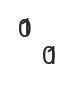

In [7]:
%load_ext autoreload
%autoreload 2x
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
pd.set_option("display.max_columns",999)
pd.set_option("display.max_rows",100)

import warnings
warnings.filterwarnings("ignore")

import src.models
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch import optim
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side
from src.data_processing import encode_batch_weighted, onehot_batch_decode, onehot_decode, INT_TO_CHAR, HLAS, AA_KEYS
from src.data_processing import get_tensor_dataset, encode_batch, BL62_VALUES, BL62FREQ_VALUES, get_array_dataset
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from src.metrics import get_metrics, plot_roc_auc_fold, get_mean_roc_curve, get_pred_df, get_mean_pr_curve
from src.metrics import get_nested_feature_importance, plot_feature_importance
from src.train_eval import kcv_tune_sklearn, evaluate_trained_models_sklearn, nested_kcv_train_sklearn
from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump

from scipy.stats import ttest_ind, mannwhitneyu, wilcoxon
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

PAL = sns.color_palette('hsv', n_colors=13)
HSV = [PAL[-4], PAL[-1], PAL[0], PAL [4]]
mpl.rcParams['figure.dpi'] = 180

RESDIR='../output/220906_analysis/'
BOOTDIR='../output/bootstrapping/'

if torch.cuda.is_available():
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name())
    device="cuda:0"
else:
    print('No GPU available, using the CPU instead.')
    device='cpu'
    

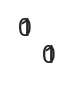

In [8]:
mpl.rcParams['figure.dpi'] = 180
sns.set_palette(HSV)
f,a = plt.subplots(1,1,figsize=(1e-7,1e-7))

# init

## reloading datasets

In [4]:
cedar = pd.read_csv('../data/partitioned_traindata/cedar_10fold.csv')
cedar['trainset']='cedar'

cedar_viral_old = pd.read_csv('../data/partitioned_traindata/cedar_viral_10fold.csv')
cedar_viral_old['trainset']='cedar_virus_old'

cedar_viral_more = pd.read_csv('../data/partitioned_traindata/new_cedar_viral_5fold.csv')
cedar_viral_more['trainset']='cedar_virus_new'
# USE PRIME FOR BASELINE VERIFICATION, PRIME_FOLD FOR ACTUAL TRAINING
prime_fold = pd.read_csv('../data/partitioned_traindata/prime_5fold.csv')
prime_fold['trainset']='prime'

prime = pd.read_excel('../data/partitioned_traindata/PRIME_dataset.xlsx', comment = '#', skiprows=2)
prime['len'] = prime['Mutant'].apply(len)
prime['HLA'] = prime['Allele'].apply(lambda x: 'HLA-'+x)

viral_only = pd.read_csv('../data/partitioned_traindata/viral_only_5fold.csv')
viral_only['trainset']='virus'

cedar_hp_uni = pd.read_csv('../data/partitioned_traindata/cedar_hp_mixed_rank120_10fold.csv')
cedar_hp_uni['trainset']='cedar_hp_rank_uni'

cedar_hp_low = pd.read_csv('../data/partitioned_traindata/cedar_hp_mixed_10fold.csv')
cedar_hp_low['trainset']='cedar_hp_rank_low'

cedar_hp_fold = pd.read_csv('../data/partitioned_traindata/cedar_hp_fold_balanced.csv')
cedar_hp_fold['trainset'] = 'cedar_balanced'

cedar_mut_fold = pd.read_csv('../data/partitioned_traindata/cedar_subst_mut_10fold.csv')

In [5]:
cedar_related = pd.read_csv('../data/mutant/220927_cedar_related_scored.csv')
prime_related = pd.read_csv('../data/mutant/220927_prime_neoepi_related_scored.csv')

In [6]:
# ICS DICT
ics_kl = pkl_load('../data/ic_dicts/ics_kl.pkl')
ics_shannon = pkl_load('../data/ic_dicts/ics_shannon.pkl')

MAPPING= {'RandomForestClassifier': 'RF',
          'LogisticRegression': 'LogReg',
          'XGBClassifier': 'XGB',
          'FFN': 'FFN'}

## Baselines

3480


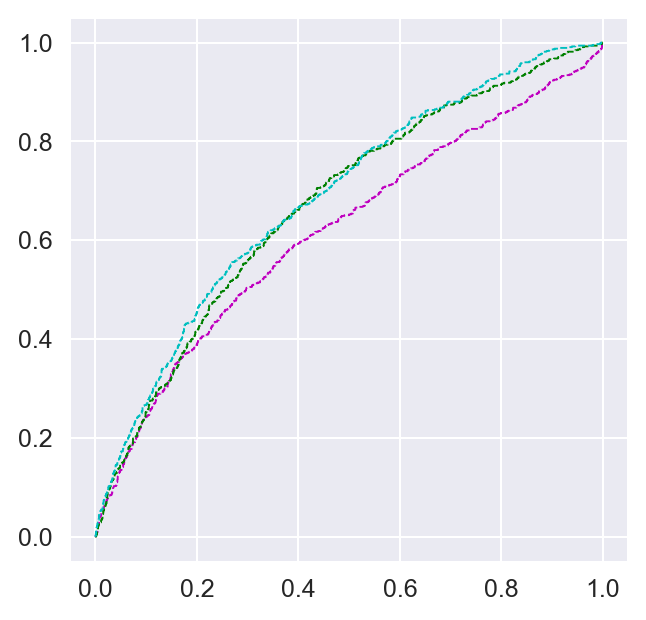

In [6]:
from src.baselines import plot_baseline_roc, plot_related_baseline_roc
cedar_baseline = pd.read_csv('../data/baselines/cedar_baseline.csv')
cedar_related_baseline = pd.read_csv('../data/baselines/cedar_related_baseline.csv')
prime = pd.read_csv('../data/baselines/prime_baseline.csv')
prime_related_baseline = pd.read_csv('../data/baselines/prime_related_baseline.csv')
f,a = plt.subplots(1,1, figsize=(4,4))
plot_baseline_roc(a, cedar_baseline)

In [7]:
prime_related.columns.difference(prime_related_baseline.columns)

Index(['Allele', 'IEDB', 'Immunogenicity', 'MixMHCpred', 'NetMHCpanEL',
       'NetMHCpanEL_WT', 'PRIME', 'VHSE1', 'VHSE3', 'VHSE7', 'VHSE8',
       'aliphatic_index', 'boman', 'hydrophobicity', 'isoelectric_point'],
      dtype='object')

# Redefine anchor/netmhcpan

## reading

In [70]:
cedar_related.query('mutation_type == "substitution"')

UndefinedVariableError: name 'mutation_type' is not defined

In [190]:
cedar_related_fold = pd.read_csv('../data/partitioned_traindata/cedar_subst_mut_10fold.csv')
print(len(cedar_related_fold))
cedar_related_fold.head()

3033


,Peptide,wild_type,len,HLA,trueHLA_EL_rank,wt_EL_rank,ratio_rank,fold,agg_label,binder,anchor_mutation,mutation_position,mutation_type,mutation_score,blsm_mut_score,BA_rank,BA_score,HLA_full,PMIDs,Related Object_Ending Position,Related Object_Starting Position,core,core_mutation_position,delta_VHSE1,delta_VHSE3,delta_VHSE7,delta_VHSE8,delta_aliphatic_index,delta_boman,delta_hydrophobicity,delta_isoelectric_point,delta_rank,icore,label,len_wt,mhc_anchor,percentage_pos,pred_EL_rank,pred_EL_score,pred_HLA,responses,total_count,trainset,wt_core,wt_true
0,AAAAAAQQIQV,AAAAAAQQLQV,11,HLA-B0702,26.7692,25.5667,0.955079,6,0,Conserved,0,8,substitution,1.386294,1.386294,11.9024,0.1632,HLA-B*07:02,27198675,167.0,157.0,AAAAAQIQV,6,-0.008182,-0.005455,-0.021818,0.044545,0.000000,0.000000,0.063636,0.0,-1.2025,AAAAAAQQIQV,Negative,11,"1,8",0.0,5.2822,0.0166,HLA-A68:02,Negative,1,cedar,AAAAAQLQV,True
1,AAAAQQIQV,AAAAQQLQV,9,HLA-A0201,1.9555,2.2847,1.168346,6,0,Conserved,0,6,substitution,1.386294,1.386294,0.3045,0.4709,HLA-A*02:01,27198675,167.0,159.0,AAAAQQIQV,6,-0.010000,-0.006667,-0.026667,0.054444,0.000000,0.000000,0.077778,0.0,0.3292,AAAAQQIQV,Negative,9,"1,3,8",0.0,0.1036,0.6567,HLA-C15:02,Negative,1,cedar,AAAAQQLQV,True
2,AAAAQQIQV,AAAAQQLQV,9,HLA-B0702,4.9092,4.7746,0.972582,6,0,Conserved,0,6,substitution,1.386294,1.386294,0.3045,0.4709,HLA-B*07:02,27198675,167.0,159.0,AAAAQQIQV,6,-0.010000,-0.006667,-0.026667,0.054444,0.000000,0.000000,0.077778,0.0,-0.1346,AAAAQQIQV,Negative,9,"1,8",0.0,0.1036,0.6567,HLA-C15:02,Negative,1,cedar,AAAAQQLQV,True
3,AAHFTVLLY,AAHFTALLY,9,HLA-A1101,0.4196,0.5881,1.401573,8,0,Conserved,0,5,substitution,1.386294,1.386294,0.1083,0.6509,HLA-A*11:01,31511069,1957.0,1949.0,AAHFTVLLY,5,0.067778,0.131111,-0.066667,0.050000,21.111111,-0.247778,0.266667,0.0,0.1685,AAHFTVLLY,Negative,9,"0,1,8",0.0,0.0256,0.8170,HLA-A30:02,Negative,1,cedar,AAHFTALLY,True
4,AAIAASRSV,AAIAASRSA,9,HLA-C1203,0.0591,1.1729,19.846024,7,0,Improved,1,8,substitution,1.386294,1.386294,0.0580,0.7400,HLA-C*12:03,30556813,14.0,6.0,AAIAASRSV,8,0.067778,0.131111,-0.066667,0.050000,21.111111,-0.247778,0.266667,0.0,1.1138,AAIAASRSV,Negative,9,"1,8",0.0,0.0591,0.6191,HLA-C12:03,Negative,1,cedar,AAIAASRSA,True


In [191]:
cedar_related_fold['seq_id'] = [f'seq{i}' for i in range(1, len(cedar_related_fold)+1)]

## Writing into ""fasta"" file

In [192]:
','.join(sorted(cedar_related_fold.HLA_full.unique()))

'HLA-A*01:01,HLA-A*02:01,HLA-A*02:02,HLA-A*02:03,HLA-A*02:05,HLA-A*02:06,HLA-A*02:10,HLA-A*02:11,HLA-A*02:24,HLA-A*03:01,HLA-A*03:02,HLA-A*11:01,HLA-A*11:02,HLA-A*24:02,HLA-A*25:01,HLA-A*26:01,HLA-A*29:02,HLA-A*30:01,HLA-A*30:02,HLA-A*31:01,HLA-A*33:01,HLA-A*68:01,HLA-A*68:02,HLA-A*69:01,HLA-B*07:02,HLA-B*08:01,HLA-B*13:02,HLA-B*15:01,HLA-B*18:01,HLA-B*27:05,HLA-B*35:01,HLA-B*35:03,HLA-B*37:01,HLA-B*37:04,HLA-B*38:01,HLA-B*39:01,HLA-B*39:06,HLA-B*40:01,HLA-B*40:02,HLA-B*41:02,HLA-B*44:02,HLA-B*44:03,HLA-B*44:08,HLA-B*49:01,HLA-B*51:01,HLA-B*52:01,HLA-B*54:01,HLA-B*56:01,HLA-B*57:01,HLA-C*01:02,HLA-C*03:03,HLA-C*03:04,HLA-C*04:01,HLA-C*05:01,HLA-C*06:02,HLA-C*07:01,HLA-C*07:02,HLA-C*08:02,HLA-C*12:02,HLA-C*12:03,HLA-C*14:02,HLA-C*14:03,HLA-C*15:02'

In [193]:
f_mut = open('../../netmhcpan/cedar_related_mut.fa', 'w')
f_wt = open('../../netmhcpan/cedar_related_wt.fa', 'w')

for i, row in cedar_related_fold.iterrows():
    f_mut.writelines([f">{row['seq_id']}\n", f"{row['Peptide']}\n"])
    f_wt.writelines([f">{row['seq_id']}\n", f"{row['wild_type']}\n"])

f_mut.close()
f_wt.close()

## Parsing xls

In [165]:
ss = ['AEAERLDVKAI','AALHTPRPGPL']
test = cedar_related_fold.query('Peptide in @ss').reset_index(drop=True)
test=test.replace('HLA-B4403', 'HLA-A0201')
test['seq_id'] = ['seq2', 'seq1']
test = test[['Peptide', 'HLA', 'seq_id']]
test

,Peptide,HLA,seq_id
0,AALHTPRPGPL,HLA-B0702,seq2
1,AEAERLDVKAI,HLA-A0201,seq1


In [166]:
# Ranks stuff
from src.utils import read_netmhcpan_results, flatten_level_columns
from src.utils import get_trueHLA_EL_rank
test_xls = read_netmhcpan_results('../data/test.xls')
test_xls.columns = pd.MultiIndex.from_tuples([(x.replace(':','').replace('HLA-',''), y) for x,y in test_xls.columns])
display(test_xls)
# display(flatten_level_columns(test_xls.head()))

base                         A0201                                 \
    Pos      Peptide    ID       core        icore EL-score  EL_Rank   
0     0  AEAERLDVKAI  seq1  AEAEDVKAI  AEAERLDVKAI   0.0003  30.1364   
1     0   AEAERLDVKA  seq1  AEAERLVKA   AEAERLDVKA   0.0005  24.1458   
2     1   EAERLDVKAI  seq1  EAERLDVAI   EAERLDVKAI   0.0001  50.0000   
3     0    AEAERLDVK  seq1  AEAERLDVK    AEAERLDVK   0.0002  35.7692   
4     1    EAERLDVKA  seq1  EAERLDVKA    EAERLDVKA   0.0001  48.4000   
5     2    AERLDVKAI  seq1  AERLDVKAI    AERLDVKAI   0.0004  26.6316   
6     0     AEAERLDV  seq1  AEAERLD-V     AEAERLDV   0.0000  55.4545   
7     1     EAERLDVK  seq1  EA-ERLDVK     EAERLDVK   0.0000  80.0000   
8     2     AERLDVKA  seq1  AER-LDVKA     AERLDVKA   0.0000  76.6667   
9     3     ERLDVKAI  seq1  ERLDVK-AI     ERLDVKAI   0.0000  70.0000   
10    0  AALHTPRPGPL  seq2  ALHTPRPGL   ALHTPRPGPL   0.0005  23.6182   
11    0   AALHTPRPGP  seq2  ALHTPRPGP   AALHTPRPGP   0.0009  18.6532   
12    1   ALHTPRPGPL  seq2  ALHTPRPGL   ALHTPRPGPL   0.0229   4.4505   
13    0    AALHTPRPG  seq2  AALHTPRPG    AALHTPRPG   0.0000  65.0000   
14    1    ALHTPRPGP  seq2  ALHTPRPGP    ALHTPRPGP   0.0065   8.1856   
15    2    LHTPRPGPL  seq2  LHTPRPGPL    LHTPRPGPL   0.0001  45.0000   
16    0     AALHTPRP  seq2  AALH-TPRP     AALHTPRP   0.0000  52.3333   
17    1     ALHTPRPG  seq2  ALHTPRPG-     ALHTPRPG   0.0001  43.2857   
18    2     LHTPRPGP  seq2  -LHTPRPGP     LHTPRPGP   0.0000  67.5000   
19    3     HTPRPGPL  seq2  HTPRPGP-L     HTPRPGPL   0.0002  30.3636   

        B0702                                    end     
         core        icore EL-score  EL_Rank     Ave NB  
0   AEAEDVKAI  AEAERLDVKAI   0.0003  25.4667  0.0003  0  
1   AEAERLVKA   AEAERLDVKA   0.0001  34.9091  0.0003  0  
2   EARLDVKAI   EAERLDVKAI   0.0010  15.0148  0.0005  0  
3   AEAERLDVK    AEAERLDVK   0.0002  29.8235  0.0002  0  
4   EAERLDVKA    EAERLDVKA   0.0001  35.2222  0.0001  0  
5   AERLDVKAI    AERLDVKAI   0.0037   8.2857  0.0020  0  
6   AEAERLD-V     AEAERLDV   0.0001  35.3333  0.0001  0  
7   EA-ERLDVK     EAERLDVK   0.0000  63.5714  0.0000  0  
8   AER-LDVKA     AERLDVKA   0.0001  48.7500  0.0000  0  
9   ERLDVK-AI     ERLDVKAI   0.0002  31.7333  0.0001  0  
10  AALPRPGPL  AALHTPRPGPL   0.0143   4.2778  0.0074  0  
11  AAHTPRPGP   AALHTPRPGP   0.0002  29.1765  0.0006  0  
12  ALHTPRPPL   ALHTPRPGPL   0.0383   2.5335  0.0306  0  
13  AALHTPRPG    AALHTPRPG   0.0002  27.7143  0.0001  0  
14  ALHTPRPGP    ALHTPRPGP   0.0016  12.1949  0.0041  0  
15  LHTPRPGPL    LHTPRPGPL   0.0095   5.2754  0.0048  0  
16  AALHTPRP-     AALHTPRP   0.0000  49.6667  0.0000  0  
17  ALHTPRPG-     ALHTPRPG   0.0001  35.8889  0.0001  0  
18  LHT-PRPGP     LHTPRPGP   0.0001  44.2500  0.0000  0  
19  HT-PRPGPL     HTPRPGPL   0.0116   4.7653  0.0059  0

In [198]:
def parse_netmhcpan_shift(row, netmhc_xls):
    hla = row['HLA'].replace(':','').replace('HLA-','')
    seq_id = row['seq_id']
    tmp = netmhc_xls.query('@netmhc_xls.base.ID==@seq_id')
    tmp = tmp[[x for x in tmp.columns if x[0]==hla or x[0]=='base']]
    argmin = tmp.iloc[tmp[(hla, 'EL_Rank')].argmin()].droplevel(0).rename({'Peptide':'Sub_peptide',
                                                                           'EL_Rank':'shifted_EL_rank'})
    try:
        return argmin.drop(['EL-score','ID'])
    
    except:
        print('here')
        return argmin['Pos'], argmin['Peptide'], argmin['core'], argmin['icore'], argmin['EL_Rank']

In [ ]:
test.merge(test.apply(parse_netmhcpan_shift, netmhc_xls=test_xls, axis=1, result_type='expand'),
           left_index=True, right_index=True)

here
here


,Peptide,HLA,seq_id,Pos,Sub_peptide,core,icore,EL_Rank
0,AALHTPRPGPL,HLA-B0702,seq2,1,ALHTPRPGPL,ALHTPRPPL,ALHTPRPGPL,2.5335
1,AEAERLDVKAI,HLA-A0201,seq1,0,AEAERLDVKA,AEAERLVKA,AEAERLDVKA,24.1458


In [217]:
mutant_xls = read_netmhcpan_results('../../netmhcpan/score_shift/output/cedar_related_mut.fa.xls')
wt_xls = read_netmhcpan_results('../../netmhcpan/score_shift/output/cedar_related_wt.fa.xls')
mutant_xls.columns = pd.MultiIndex.from_tuples([(x.replace(':','').replace('HLA-',''), y) for x,y in mutant_xls.columns])
wt_xls.columns = pd.MultiIndex.from_tuples([(x.replace(':','').replace('HLA-',''), y) for x,y in wt_xls.columns])

new_cedar_mut = cedar_related_fold.merge(cedar_related_fold.apply(parse_netmhcpan_shift, netmhc_xls = mutant_xls, 
                                                  axis = 1, result_type='expand'), left_index=True, right_index=True)
new_cedar_wt = cedar_related_fold.merge(cedar_related_fold.apply(parse_netmhcpan_shift, netmhc_xls = wt_xls,
                                                                 axis=1, result_type='expand'), left_index=True, right_index=True)

In [219]:
new_cedar_mut.to_csv('../data/mutant/new_cedar_mut.csv', index=False)
new_cedar_wt.to_csv('../data/mutant/new_cedar_wt.csv', index=False)

In [229]:
mrg['lencore']=mrg['core_y_mut'].apply(len)
mrg.groupby('lencore').count()

,Peptide,wild_type,len,HLA,trueHLA_EL_rank,wt_EL_rank,ratio_rank,fold,agg_label,binder,anchor_mutation,mutation_position,mutation_type,mutation_score,blsm_mut_score,BA_rank,BA_score,HLA_full,PMIDs,Related Object_Ending Position,Related Object_Starting Position,core_x,core_mutation_position,delta_VHSE1,delta_VHSE3,delta_VHSE7,delta_VHSE8,delta_aliphatic_index,delta_boman,delta_hydrophobicity,delta_isoelectric_point,delta_rank,icore_x,label,len_wt,mhc_anchor,percentage_pos,pred_EL_rank,pred_EL_score,pred_HLA,responses,total_count,trainset,wt_core,wt_true,seq_id,Pos,Sub_peptide,core_y_mut,icore_y_mut,EL_Rank_mut,core_y_wt,icore_y_wt,EL_Rank_wt
lencore,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9,3033,3033,3033,3033,3033,3033,3033,3033,3033,3033,3033,3033,3033,3033,3033,3033,3033,3033,3033,3014,3014,3033,3033,3033,3033,3033,3033,3033,3033,3033,3033,3033,3033,3033,3033,3033,3033,3033,3033,3033,3033,3033,3033,3033,3033,3033,3033,3033,3033,3033,3033,3033,3033,3033


In [230]:
mrg.query('core_y_mut.str.contains("-")', engine='python')

,Peptide,wild_type,len,HLA,trueHLA_EL_rank,wt_EL_rank,ratio_rank,fold,agg_label,binder,anchor_mutation,mutation_position,mutation_type,mutation_score,blsm_mut_score,BA_rank,BA_score,HLA_full,PMIDs,Related Object_Ending Position,Related Object_Starting Position,core_x,core_mutation_position,delta_VHSE1,delta_VHSE3,delta_VHSE7,delta_VHSE8,delta_aliphatic_index,delta_boman,delta_hydrophobicity,delta_isoelectric_point,delta_rank,icore_x,label,len_wt,mhc_anchor,percentage_pos,pred_EL_rank,pred_EL_score,pred_HLA,responses,total_count,trainset,wt_core,wt_true,seq_id,Pos,Sub_peptide,core_y_mut,icore_y_mut,EL_Rank_mut,core_y_wt,icore_y_wt,EL_Rank_wt,lencore
39,AIYHTLNLFNI,AIYHTLNLCNI,11,HLA-A0201,5.8573,7.5550,1.289843,8,0,Conserved,1,8,substitution,0.693147,0.693147,3.3228,0.5239,HLA-A*02:01,31511069,312.0,302.0,AIYHNLFNI,"4,6",0.121818,0.129091,0.025455,-0.000909,0.000000,-0.154545,0.027273,0.186851,1.6977,AIYHTLNLFNI,Negative,11,"1,3,8",0.0,4.7163,0.0889,HLA-A02:11,Negative,1,cedar,AIYHTLNNI,True,seq40,0,AIYHTLNL,AIY-HTLNL,AIYHTLNL,4.7939,AIYHTLNLC,AIYHTLNLC,3.4539,9
40,AKNCGIAIPV,AKNRGIAIPV,10,HLA-B0702,52.6923,32.5385,0.617519,3,0,Conserved,0,3,substitution,0.693147,0.693147,4.2239,0.1514,HLA-B*07:02,27198675,1553.0,1544.0,AKNGIAIPV,2,0.165000,-0.170000,-0.291000,-0.102000,0.000000,-1.620000,0.700000,-3.106586,-20.1538,AKNCGIAIPV,Negative,10,"1,8",0.0,12.5428,0.0052,HLA-B39:06,Negative,1,cedar,AKRGIAIPV,True,seq41,0,AKNCGIAI,-AKNCGIAI,AKNCGIAI,33.2727,KNRGIAIPV,KNRGIAIPV,7.5456,9
105,ALSIGTSYRY,ALSIGTPYRY,10,HLA-B1501,0.4303,0.4894,1.137346,2,0,Conserved,1,6,substitution,1.386294,1.386294,0.0789,0.6716,HLA-B*15:01,27198675,402.0,393.0,ASIGTSYRY,"1,5",-0.089000,-0.057000,-0.045000,-0.345000,0.000000,0.340000,0.080000,0.000000,0.0591,ALSIGTSYRY,Negative,10,"1,8",0.0,0.1108,0.6743,HLA-A30:02,Negative,1,cedar,ALIGTPYRY,True,seq106,0,ALSIGTSY,ALS-IGTSY,ALSIGTSY,0.3522,ALIGTPYRY,ALSIGTPYRY,0.4894,9
133,AMYLNYFRGL,AMYLNYCRGL,10,HLA-A0201,6.1562,9.5592,1.552776,1,0,Conserved,1,6,substitution,0.693147,0.693147,1.6241,0.2883,HLA-A*02:01,31511069,266.0,257.0,AYLNYFRGL,"1,2,5",0.134000,0.142000,0.028000,-0.001000,0.000000,-0.170000,0.030000,0.665082,3.4030,AMYLNYFRGL,Negative,10,"1,3,8",0.0,2.4364,0.0296,HLA-A24:02,Negative,1,cedar,AMYNYCRGL,True,seq134,2,YLNYFRGL,YLN-YFRGL,YLNYFRGL,5.4228,AMYNYCRGL,AMYLNYCRGL,9.5592,9
158,APTWRALAR,APTWRALAG,9,HLA-B0702,2.6840,1.4481,0.539531,2,0,Conserved,1,8,substitution,1.791759,1.791759,2.4662,0.2840,HLA-B*07:02,27198675,106.0,98.0,APTWRALAR,8,-0.141111,0.430000,-0.078889,0.241111,0.000000,1.762222,-0.455556,1.950107,-1.2359,APTWRALAR,Negative,9,"1,8",0.0,1.5988,0.1048,HLA-A33:01,Negative,1,cedar,APTWRALAG,True,seq159,0,APTWRALA,APT-WRALA,APTWRALA,2.3117,APTWRALAG,APTWRALAG,1.4481,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2838,WYTHNLIFVF,WYTHNLFFVF,10,HLA-C1403,2.8869,3.3151,1.148325,8,0,Conserved,0,6,substitution,0.693147,0.693147,0.0512,0.7123,HLA-C*14:03,24323902,34.0,25.0,WYTHNIFVF,5,-0.025000,-0.066000,0.117000,0.007000,39.000000,-0.194000,0.170000,0.000000,0.4282,WYTHNLIFVF,Negative,10,"1,8",0.0,0.4834,0.3377,HLA-A24:02,Negative,1,cedar,WYTHNFFVF,True,seq2839,0,WYTHNLIF,WYT-HNLIF,WYTHNLIF,0.5629,WYT-HNLFF,WYTHNLFF,0.6155,9
2869,YKLVVVGAV,YKLVVVGAG,9,HLA-A0201,27.7097,95.0000,3.428402,5,1,Conserved,1,8,substitution,1.386294,1.386294,0.3141,0.3925,HLA-A*02:01,"32934692,32934692,10779805",12.0,4.0,YKLVVVGAV,8,0.106667,0.273333,-0.250000,0.145556,32.222222,-0.344444,0.511111,0.000000,67.2903,YKLVVVGAV,Positive,9,"1,3,8",1.0,1.1731,0.1708,HLA-B39:06,"Positive_all,Positive_all,Positive_all",3,cedar,YKLVVVGAG,True,seq2870,1,KLVVVGAV,KLV-VVGAV,KLVVVGAV,7.6549,KLVVVGAG-,KLVVVGAG,46.6000,9
2933,YMKSLEFENK,YMKSSEFENK,10,HLA-A1101,3.9487,2.7059,0.685264,7,1,Conserved,1,4,substitution,0.693147,0.693147,0.4876,0.5396,HLA-A*11:01,"3

In [225]:
mrg = new_cedar_mut.merge(new_cedar_wt[['core_y', 'icore_y', 'EL_Rank']], left_index=True, right_index=True,
                         suffixes=['_mut', '_wt'])
mrg.query('EL_Rank_mut > 2 and EL_Rank_wt > 2')

,Peptide,wild_type,len,HLA,trueHLA_EL_rank,wt_EL_rank,ratio_rank,fold,agg_label,binder,anchor_mutation,mutation_position,mutation_type,mutation_score,blsm_mut_score,BA_rank,BA_score,HLA_full,PMIDs,Related Object_Ending Position,Related Object_Starting Position,core_x,core_mutation_position,delta_VHSE1,delta_VHSE3,delta_VHSE7,delta_VHSE8,delta_aliphatic_index,delta_boman,delta_hydrophobicity,delta_isoelectric_point,delta_rank,icore_x,label,len_wt,mhc_anchor,percentage_pos,pred_EL_rank,pred_EL_score,pred_HLA,responses,total_count,trainset,wt_core,wt_true,seq_id,Pos,Sub_peptide,core_y_mut,icore_y_mut,EL_Rank_mut,core_y_wt,icore_y_wt,EL_Rank_wt
2,AAAAQQIQV,AAAAQQLQV,9,HLA-B0702,4.9092,4.7746,0.972582,6,0,Conserved,0,6,substitution,1.386294,1.386294,0.3045,0.4709,HLA-B*07:02,27198675,167.0,159.0,AAAAQQIQV,6,-0.010000,-0.006667,-0.026667,0.054444,0.000000,0.000000,0.077778,0.000000,-0.1346,AAAAQQIQV,Negative,9,"1,8",0.0,0.1036,0.6567,HLA-C15:02,Negative,1,cedar,AAAAQQLQV,True,seq3,0,AAAAQQIQV,AAAAQQIQV,AAAAQQIQV,4.9092,AAAAQQLQV,AAAAQQLQV,4.7746
5,AALHTPRPGPL,AALHNPRPGPL,11,HLA-B0702,4.2778,3.2200,0.752723,1,0,Conserved,1,4,substitution,0.693147,0.693147,6.9173,0.1275,HLA-B*07:02,27198675,232.0,222.0,AHTPRPGPL,"1,2",0.059091,-0.016364,-0.138182,0.108182,0.000000,-0.370000,0.254545,0.000000,-1.0578,AALHTPRPGPL,Negative,11,"1,8",0.0,2.9629,0.0290,HLA-B39:01,Negative,1,cedar,AANPRPGPL,True,seq6,1,ALHTPRPGPL,ALHTPRPPL,ALHTPRPGPL,2.5335,ALHNPRPPL,ALHNPRPGPL,2.4193
10,AAQFSSDVL,AAQFSSEVL,9,HLA-B0702,2.9660,2.1080,0.710722,2,0,Conserved,0,6,substitution,1.386294,1.386294,0.3921,0.5569,HLA-B*07:02,27198675,580.0,572.0,AAQFSSDVL,6,0.003333,-0.056667,-0.097778,0.060000,0.000000,0.212222,0.000000,-0.099996,-0.8580,AAQFSSDVL,Negative,9,"1,8",0.0,0.4982,0.2268,HLA-C03:03,Negative,1,cedar,AAQFSSEVL,True,seq11,0,AAQFSSDVL,AAQFSSDVL,AAQFSSDVL,2.9660,AAQFSSEVL,AAQFSSEVL,2.1080
12,AATPVGSLY,AATPVGSSY,9,HLA-B4002,11.1987,8.8607,0.791226,0,1,Conserved,0,7,substitution,0.693147,0.693147,0.0706,0.6190,HLA-B*40:02,34290406,1154.0,1146.0,AATPVGSLY,7,0.225556,0.158889,0.080000,-0.081111,43.333333,-0.924444,0.511111,0.000000,-2.3380,AATPVGSLY,Positive,9,"1,8",1.0,0.0143,0.8260,HLA-C12:02,Positive_all,1,cedar,AATPVGSSY,True,seq13,0,AATPVGSLY,AATPVGSLY,AATPVGSLY,11.1987,AATPVGSSY,AATPVGSSY,8.8607
22,AEWRNGSTSSL,PEWRNGSTSSL,11,HLA-A6801,27.1034,64.1667,2.367478,3,0,Conserved,1,0,substitution,1.386294,1.386294,0.1638,0.6288,HLA-A*68:01,30556813,448.0,438.0,AEWGSTSSL,0,-0.006364,-0.077273,0.050000,-0.367273,9.090909,-0.164545,0.309091,0.000000,37.0633,AEWRNGSTSSL,Negative,11,"0,1,8",0.0,0.0690,0.9251,HLA-B40:01,Negative,1,cedar,PEWGSTSSL,True,seq23,1,EWRNGSTSSL,EWNGSTSSL,EWRNGSTSSL,24.2609,EWNGSTSSL,EWRNGSTSSL,24.2609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3008,YVAKYTVPV,YLAKYTVPV,9,HLA-B0702,3.5876,5.9246,1.651410,7,0,Conserved,1,1,substitution,1.791759,1.791759,0.0073,0.8795,HLA-B*07:02,31511069,188.0,180.0,YVAKYTVPV,1,-0.066667,-0.058889,-0.035556,0.065556,-11.111111,0.097778,0.044444,0.000000,2.3370,YVAKYTVPV,Negative,9,"1,8",0.0,0.0255,0.8370,HLA-A69:01,Negative,1,cedar,YLAKYTVPV,True,seq3009,0,YVAKYTVPV,YVAKYTVPV,YVAKYTVPV,3.5876,YLAKYTVPV,YLAKYTVPV,5.9246
3010,YVEYYSWLSYL,YVEYYRWLSYL,11,HLA-A0201,3.2837,7.1482,2.176874,5,0,Conserved,1,5,substitution,1.791759,1.791759,0.6491,0.4189,HLA-A*02:01,31511069,217.0,207.0,YYYSWLSYL,"1,3",0.072727,-0.210000,-0.176364,-0.065455,0.000000,-1.047273,0.336364,-2.534028,3.8645,YVEYYSWLSYL,Negative,11,"1,3,8",0.0,1.5415,0.0697,HLA-A24:02,Negative,1,cedar,YVYRWLSYL,True,seq3011,0,YVEYYSWLSYL,YVYSWLSYL,YVEYYSWLSYL,3.2837,YVYRWLSYL,YVEYYRWLSYL,7.1482
3016,YVRRVFITDDL,YVRRVFITDDF,11,HLA-B0702,7.0059,15.9407,2.275325,4,0,Conserved,1,10,substitution,1.791759,1.791759,8.1780,0.1202,HLA-B*07:02,31511069,422.0,412.0,YVRRVFITL,8,-0.014545,-0.054545,0.1281

In [221]:
len(new_cedar_related.query('EL_Rank>2')), len(new_cedar_wt.query('EL_Rank>2'))

(565, 999)

In [213]:
new_cedar_related.query('Pos!=0')[['Peptide', 'wild_type', 'trueHLA_EL_rank', 'wt_EL_rank', 'EL_Rank',
                                   'len', 'core_x', 'wt_core', 'Sub_peptide', 'core_y', 'icore_y']]

,Peptide,wild_type,trueHLA_EL_rank,wt_EL_rank,EL_Rank,len,core_x,wt_core,Sub_peptide,core_y,icore_y
5,AALHTPRPGPL,AALHNPRPGPL,4.2778,3.2200,2.5335,11,AHTPRPGPL,AANPRPGPL,ALHTPRPGPL,ALHTPRPPL,ALHTPRPGPL
6,AALLQVTLLL,AALSQVTLLL,1.1841,1.5250,0.0995,10,ALLQVTLLL,ALSQVTLLL,ALLQVTLLL,ALLQVTLLL,ALLQVTLLL
14,AEAERLDVKAI,AEAERLDVKAM,0.5602,0.3118,0.3700,11,AEAEDVKAI,AEAEDVKAM,AERLDVKAI,AERLDVKAI,AERLDVKAI
15,AEETPPFSNY,AEETPPYSNY,0.0334,0.0341,0.0056,10,AETPPFSNY,AEETPPYSY,EETPPFSNY,EETPPFSNY,EETPPFSNY
22,AEWRNGSTSSL,PEWRNGSTSSL,27.1034,64.1667,24.2609,11,AEWGSTSSL,PEWGSTSSL,EWRNGSTSSL,EWNGSTSSL,EWRNGSTSSL
...,...,...,...,...,...,...,...,...,...,...,...
3015,YVPRFVFKLYY,YVPRFVSKLYY,6.9240,3.9333,0.4181,11,YVPRFKLYY,YVFVSKLYY,VPRFVFKLY,VPRFVFKLY,VPRFVFKLY
3017,YVRVTVQARVM,CVRVTVQARVM,5.0828,18.6104,1.9540,11,YVRVTVQAM,CVRVTVQAM,RVTVQARVM,RVTVQARVM,RVTVQARVM
3020,YVTFAVSFYVV,YVTFAVSFYLV,11.6672,11.8131,0.5877,11,YVTFAVSFV,YVFAVSFYL,VTFAVSFYV,VTFAVSFYV,VTFAVSFYV
3023,YVYSVAKTDSF,HVYSVAKTDSF,8.6524,6.9362,5.5720,11,YVYSKTDSF,HVYSKTDSF,YSVAKTDSF,YSVAKTDSF,YSVAKTDSF


# Redo CEDAR filtering from datadump & Mutation fcts

## Redo parsing & check we have the same
ALL GOOD

In [32]:
from src.data_processing import AA_KEYS, BL62_VALUES, BL62, BL62FREQ_VALUES
# Reading epi & related
cedar_short = pd.read_excel('../data/raw/neo_OCT2022_full_res_assays.xlsx')
cedar_epi = pd.read_excel('../data/raw/neo_OCT2022_full_res_epitopes.xlsx')

# Adding the wild-type peptide & Merging the related info with the cedar_epi dump
rel_cols = ['Epitope_Description', 'MHC_Allele Name', 'Related Object_Description']#, 'Related Object_Starting Position', 'Related Object_Ending Position']#
related = cedar_short.sort_values('Epitope_Description').drop_duplicates(['Epitope_Description', 'MHC_Allele Name'])[rel_cols]
print(1, len(cedar_epi.query('Epitope_Description=="CLAVEEVSL"'))==0)
cedar_epi = cedar_epi.merge(related, left_on=['Epitope_Description', 'MHC_Allele Name'], right_on = ['Epitope_Description', 'MHC_Allele Name'])
print(2, len(cedar_epi.query('Epitope_Description=="CLAVEEVSL"'))==0)
print('After merge', len(cedar_epi))

# Get the length of the peptide & Querying only length 8 to 12 (Only lens for which we have our motifs)
cedar_epi['len'] = cedar_epi['Epitope_Description'].apply(len)
cedar_epi = cedar_epi.query('len>=8 and len <=12')
print(3, len(cedar_epi.query('Epitope_Description=="CLAVEEVSL"'))==0)
print('After len check', len(cedar_epi))

# Filter out XYZ- etc characters in peptide
cedar_epi.drop(index=cedar_epi.loc[cedar_epi['Epitope_Description'].apply(lambda x: any([z for z in x if z not in AA_KEYS]))].index, inplace=True)
print(4, len(cedar_epi.query('Epitope_Description=="CLAVEEVSL"'))==0)
print('After XYZ', len(cedar_epi))

# Keeping on HLA alleles where there is at least one positive Peptide (i.e. discard Alleles with only negatives)
hlas_to_keep = [x for x in cedar_epi.query('label=="Positive"')['MHC_Allele Name'].unique() if 'D' not in x]
print('N HLAs to keep', len(hlas_to_keep))
cedar_epi = cedar_epi.query('`MHC_Allele Name` in @hlas_to_keep')
print(5, len(cedar_epi.query('Epitope_Description=="CLAVEEVSL"'))==0)

print('After HLA positive', len(cedar_epi))

# Keeping only MHC Class I
cedar_epi = cedar_epi.query('not `MHC_Allele Name`.str.contains("D")', engine='python')
print(6, len(cedar_epi.query('Epitope_Description=="CLAVEEVSL"'))==0)
print('After class II', len(cedar_epi))

# Adding some new columns
cedar_epi['total_count'] = cedar_epi['responses'].apply(lambda x: len(x.split(',')))
cedar_epi['percentage_pos'] = (cedar_epi['responses'].apply(lambda x: sum([1 for x in x.split(',') if 'Positive' in x]))/cedar_epi['total_count'])
cedar_epi['agg_label']=cedar_epi['label'].apply(lambda x: 1 if x=='Positive' else 0)

# Renaming columns 
cedar_epi.rename(columns = {'Epitope_Description': 'Peptide',
                            'MHC_Allele Name': 'HLA',
                             'Related Object_Description': 'wild_type'}, inplace=True)
# replacing HLA to simple form
cedar_epi['HLA_full'] = cedar_epi['HLA']
cedar_epi['HLA'] = cedar_epi['HLA_full'].apply(lambda x: x.replace('*','').replace(':',''))

1 False
2 False
After merge 3984
3 False
After len check 3692
4 False
After XYZ 3692
N HLAs to keep 65
5 False
After HLA positive 3570
6 False
After class II 3570


## some align/mutation fct defs

In [33]:
alphabet_file = '../data/' + "Matrices/alphabet"
alphabet = np.loadtxt(alphabet_file, dtype=str)
blosum_file = '../data/' + "Matrices/BLOSUM50"
_blosum50 = np.loadtxt(blosum_file, dtype=float).reshape((24, -1)).T

blosum50 = {}

for i, letter_1 in enumerate(alphabet):
    
    blosum50[letter_1] = {}

    for j, letter_2 in enumerate(alphabet):
        
        blosum50[letter_1][letter_2] = _blosum50[i, j]

def smith_waterman_alignment(query="VLLP", database="VLILP", scoring_scheme={}, gap_open=-2, gap_extension=-1):

    # Matrix imensions
    M = len(query)
    N = len(database)
    
    # D matrix change to float
    D_matrix = np.zeros((M+1, N+1), np.int)

    # P matrix
    P_matrix = np.zeros((M+1, N+1), np.int)
    
    # Q matrix
    Q_matrix = np.zeros((M+1, N+1), np.int)

    # E matrix
    E_matrix = np.zeros((M+1, N+1), dtype=object)

    # Initialize matrices
    for i in range(M, 0, -1):
        # Here you might include  penalties for end gaps, i.e
        # alignment_matrix[i-1, N] = alignment_matrix[i, N] + gap_open
        D_matrix[i-1, N] = 0
        P_matrix[i-1, N] = 0
        Q_matrix[i-1, N] = 0
        E_matrix[i-1, N] = 0

    for j in range(N, 0, -1):
        # Here you might include  penalties for end gaps, i.e
        #alignment_matrix[M, j-1] = alignment_matrix[M, j] + gap_open
        D_matrix[M, j-1] = 0
        P_matrix[M, j-1] = 0
        Q_matrix[M, j-1] = 0
        E_matrix[M, j-1] = 0

        
    # Main loop
    D_matrix_max_score, D_matrix_i_max, D_matrix_i_max = -9, -9, -9
    for i in range(M-1, -1, -1): 
        for j in range(N-1, -1, -1):
            
            # Q_matrix[i,j] entry
            gap_open_database = D_matrix[i+1,j] + gap_open
            gap_extension_database = Q_matrix[i+1,j] + gap_extension
            max_gap_database = max(gap_open_database, gap_extension_database)
            
            Q_matrix[i,j] = max_gap_database
                
            # P_matrix[i,j] entry
            gap_open_query = D_matrix[i,j+1] + gap_open
            gap_extension_query = P_matrix[i,j+1] + gap_extension
            max_gap_query = max(gap_open_query, gap_extension_query)
            
            P_matrix[i,j] = max_gap_query
            
            # D_matrix[i,j] entry
            diagonal_score = D_matrix[i+1,j+1]+blosum50[database[j]][query[i]]
            
            # E_matrix[i,j] entry
            candidates = [(1, diagonal_score),
                          (2, gap_open_database),
                          (4, gap_open_query),
                          (3, gap_extension_database),
                          (5, gap_extension_query)]
            
            direction, max_score = max(candidates, key=lambda x: x[1])
            
            # check entry sign
            if max_score > 0:
                E_matrix[i,j] = direction
                D_matrix[i, j] = max_score
            else:
                E_matrix[i,j] = 0
                D_matrix[i, j] = 0

            # fetch global max score
            if max_score > D_matrix_max_score:
                D_matrix_max_score = max_score
                D_matrix_i_max = i
                D_matrix_j_max = j
            
    return P_matrix, Q_matrix, D_matrix, E_matrix, D_matrix_i_max, D_matrix_j_max, D_matrix_max_score

def smith_waterman_traceback(E_matrix, D_matrix, i_max, j_max, query="VLLP", database="VLILP", gap_open=-2, gap_extension=-1):
    
    M = len(query)
    N = len(database)
    
    aligned_query = []
    aligned_database = []
    positions = []
    matches = 0
    
    # start from max_i, max_j
    i, j = i_max, j_max
    while i < M and j < N :

        positions.append([i,j])
        
        # E[i,j] = 0, stop back tracking
        if E_matrix[i, j] == 0:
            break
        
        # E[i,j] = 1, match
        if E_matrix[i, j] == 1:
            aligned_query.append(query[i])
            aligned_database.append(database[j])
            if (query[i] == database[j]):
                matches += 1
            i += 1
            j += 1
        
        
        # E[i,j] = 2, gap opening in database
        if E_matrix[i, j] == 2:
            aligned_database.append("-")
            aligned_query.append(query[i])
            i += 1

            
        # E[i,j] = 3, gap extension in database
        if E_matrix[i, j] == 3:
            
            count = i + 2
            score = D_matrix[count, j] + gap_open + gap_extension

            # Find length of gap (check if score == D_matrix[i, j])
            while((score - D_matrix[i, j])*(score - D_matrix[i, j]) >= 0.00001): 
                count += 1
                score = D_matrix[count, j] + gap_open + (count-i-1)*gap_extension

            for k in range(i, count):
                aligned_database.append("-")
                aligned_query.append(query[i])
                i += 1
             
          
        # E[i,j] = 4, gap opening in query
        if E_matrix[i, j] == 4:
            aligned_query.append("-")
            aligned_database.append(database[j])
            j += 1
        
        
        # E[i,j] = 5, gap extension in query
        if E_matrix[i, j] == 5:
            
            count = j + 2
            score = D_matrix[i, count] + gap_open + gap_extension
            
            # Find length of gap (check if score == D_matrix[i, j])
            while((score - D_matrix[i, j])*(score - D_matrix[i, j]) >= 0.0001): 
                count += 1
                score = D_matrix[i, count] + gap_open + (count-j-1)*gap_extension

            for k in range(j, count):
                aligned_query.append("-")
                aligned_database.append(database[j])
                j += 1
    return aligned_query, aligned_database, matches

database = 'RSQWVLRGAE'
query = 'KITQNSKK'
scoring_scheme = blosum50
gap_open = -2
gap_extension = -1
P_matrix, Q_matrix, D_matrix, E_matrix, i_max, j_max, max_score = smith_waterman_alignment(query, database, scoring_scheme, gap_open, gap_extension)
aligned_query, aligned_database, matches = smith_waterman_traceback(E_matrix, D_matrix, i_max, j_max, query, database, gap_open, gap_extension)

print("QAL", ''.join(aligned_query))
print("DAL", ''.join(aligned_database))

QAL KITQ
DAL R-SQ


In [34]:
def pipeline_align(query, database, blosum=BL62, gap_open=-1, gap_extension=-1, print_=False):
    P_matrix, Q_matrix, D_matrix, E_matrix, i_max, j_max, max_score = smith_waterman_alignment(query, database, BL62, gap_open, gap_extension)
    aligned_query, aligned_database, matches = smith_waterman_traceback(E_matrix, D_matrix, i_max, j_max, query, database, gap_open, gap_extension)
    if print_:
        return ''.join(aligned_query), ''.join(aligned_database), matches#/len(aligned_query)
    else:
        return matches/len(aligned_query)
    
    
# Only keep Wild Type which are peptides (& not some protein name)
def check_wt(string):
    if ' ' in string:
        return False
    if any([(x not in AA_KEYS) for x in string]):
        return False
    if string != string.upper():
        return False
    else:
        return True


def get_mutation_type(mutant, wildtype):
    if mutant==wildtype:
        return 'same'
    if len(mutant) == len(wildtype):
        # Allowing up to 3 substitution (some of them could be on anchors)
        if sum(1 for a, b in zip(mutant, wildtype) if a != b)/len(mutant)<=3/8:
            return 'substitution'
        else:
            return 'else'
    elif len(mutant)!=len(wildtype):
        try: 
            aligned_query, aligned_database, matches = pipeline_align(mutant, wildtype, print_=True)
        except:
            print(mutant, wildtype)
        len_align = len(aligned_query)
        if len_align==0:
            return 'else'
        if matches/len_align < 0.6:
            return 'else'     
        else:
            # If mutant longer than wildtype, has to be insertion, except frameshift which 
            # makes the mutant very different
            if len(mutant)>len(wildtype): 
                return 'insertion'
            # Missing amino acids, should be deletions ; could also be frameshift if very different
            if len(mutant)<len(wildtype):
                return 'deletion'
            
def get_mutation_pos(mutant, wildtype, mut_type):
    if mutant==wildtype:
        return str(-1)
    if mut_type=='substitution':
        # Here just use the full mutant & wt, and not the core
        return ','.join([str(i) for i,z in enumerate([x!=y for x,y in zip(mutant, wildtype)]) if z])
    else:
        return str(-1)

def get_anchor(allele, ic_dict, threshold=0.1615):
    """
    rank is the % rank at which we take the IC ; will use .25
    threshold is the threshold for info content to count as anchor
    ONLY USE 9MER MOTIF ; Use core/wt_core to check if anchor mutation if len!=9
    """
    info_content = ic_dict[9][allele][.25]
    return ','.join(np.where(info_content>=threshold)[0].astype(str))

def get_anchor_mutation(mutant, wildtype, mut_core, wt_core, len_, anchor, mut_type):
    """
    Check if len==9 ; If not, use the core / wt_core to get mutation anchor or not
    """
    if mut_type != 'substitution':
        return False
    if len_ == 9:
        return str(get_mutation_pos(mutant, wildtype, mut_type)) in anchor
    else:
        if mut_core==wt_core:
            return False
        else:
            return any([x in anchor for x in get_mutation_pos(mut_core, wt_core, mut_type)])

def get_binder_type(mut_rank, wt_rank):
    """
    Based on the fact that Improved binder should mean that the immune system hasn't 
    tolerized against the wild-type peptide, i.e. wt_rank>2%
    So WT should technically be a non-binder to get improved ; 
    If WT is a non binder, can check that the ratio of of wt_rank/mut_rank > 1.35 (value decided empirically)
    
    If WT is a binder, can still consider a 5-fold ratio to be an improvement.
    ex: wt_rank = 0.5%, mut_rank = 0.1%
    """
    ratio = wt_rank/mut_rank
    if wt_rank>=2:
        if mut_rank<2:
            if ratio < 3: # 
                return 'Conserved'
            else:
                return 'Improved'
        elif mut_rank >=2:
            return 'Conserved'
        
    elif wt_rank<2:
        if mut_rank>=2:
            return 'Conserved'
        elif mut_rank <2:
            if ratio >= 4: # Chose 4 because this adds exactly 101 peptides to the Improved class lol
                return 'Improved'
            else:
                return 'Conserved'

## apply

In [35]:
cedar_epi['wt_true'] = cedar_epi['wild_type'].apply(check_wt)
cedar_epi['len_wt'] = cedar_epi['wild_type'].apply(len)
# Only keep those that have the true wild-type peptide indicated and not something else
print(len(cedar_epi.query('Peptide=="CLAVEEVSL"'))==0)
print(len(cedar_epi))

False
3570


In [49]:
cedar_related = cedar_epi.query('wt_true and HLA in @HLAS').copy()
non_in_hlas = cedar_epi.query('wt_true and HLA not in @HLAS').copy()
len(cedar_related), len(non_in_hlas.HLA.unique()), non_in_hlas.HLA.unique()

(3450,
 5,
 array(['HLA-B5801', 'HLA-A3303', 'HLA-C0302', 'HLA-B4003', 'HLA-B1502'],
       dtype=object))

In [48]:
cedar_related = cedar_epi.query('wt_true and HLA in @HLAS').copy()
cedar_related['mutation_type'] = cedar_related.apply(lambda x: get_mutation_type(x['Peptide'], x['wild_type']), axis=1)
cedar_related['mhc_anchor'] = cedar_related.apply(lambda x: get_anchor(x['HLA'].replace(':',''), ics_kl, threshold=.1615), axis=1)
cedar_related['mutation_position'] = cedar_related.apply(lambda x: get_mutation_pos(x['Peptide'], x['wild_type'], x['mutation_type']), axis=1)
cedar_related['anchor_mutation'] = cedar_related.apply(lambda x: get_anchor_mutation(x['Peptide'], x['wild_type'], 
                                                                                     x['core'], x['wt_core'], 
                                                                                     x['len'], x['mhc_anchor'],
                                                                                     x['mutation_type']), axis=1)
cedar_related['core_mutation_position'] = cedar_related.apply(lambda x: get_mutation_pos(x['core'], x['wt_core'], x['mutation_type']), axis=1)
cedar_related['binder'] = cedar_related.apply(lambda x: get_binder_type(x['trueHLA_EL_rank'], x['wt_EL_rank']), axis=1)
cedar_related['ratio_rank'] = cedar_related['wt_EL_rank']/cedar_related['trueHLA_EL_rank']

cedar_related['HLA_full']= cedar_related['HLA'].apply(lambda x: x[:5]+'*'+x[5:])
cedar_related['HLA'] = cedar_related['HLA'].str.replace(':','')

KeyError: 'core'

### Quick checks & filtering

In [23]:
# Quick check
res = []
for x,y in cedar_epi.query('len_wt != len and wt_true ==True')[['Peptide', 'wild_type']].drop_duplicates().values:
    percents = pipeline_align(x,y, print_=False)
    res.append({'Peptide':x,
                'wild_type':y,
                'percent_match':percents})
df_match = pd.DataFrame(res)

In [24]:
for t in [.3, .4, .5, .66, .7, .75]:
    tmp = df_match.query('percent_match<=@t')
    print(t, len(tmp),'\n',tmp.sample(3))

0.3 34 
          Peptide    wild_type  percent_match
98     TARKCTGGK   RAYEAHDENK       0.181818
104     TTSGTSQY  ETFAPGPRRLY       0.300000
71   QIFLSEIRWEK     ITNYIVEK       0.250000
0.4 58 
         Peptide    wild_type  percent_match
22  GINYHSSFGCK     HVADVSLR       0.200000
92  SIYWAYDNGIK    RTNEPQKLK       0.250000
51    KVRCSGLHK  QTFLSEIRWEK       0.222222
0.5 69 
         Peptide  wild_type  percent_match
107  VIHNFLFSLK   QITQNSKK           0.40
110  VMLRVQPEGK   RMARSSPY           0.50
72     QLANGAFK  HPQEVYNEY           0.25
0.66 74 
         Peptide   wild_type  percent_match
103  TTETPSASLY    LTINSIIY       0.333333
79     RMARSAPY  SMKGHEKTAK       0.250000
23    GLANQQSLK    AIYKQSQH       0.333333
0.7 79 
        Peptide         wild_type  percent_match
35  ISVPFSAKRK       WISVPFSRTLK       0.666667
40  KIPVAITSPK  KIPVAIKELREATSPK       0.625000
30   HTQEVYNEY       SKIEEPSPIVY       0.375000
0.75 83 
         Peptide    wild_type  percent_match
62  MLNELKST

### netmhcpan

In [19]:
# Saving only the wild-type peps that are longer than 8 aa 
cedar_related = cedar_epi.query('len_wt>8')
# cedar_related['HLA']=cedar_related['HLA'].str.replace(':','')
cedar_related['wild_type'].to_csv('../../../kern_dist/cedar_related.pep', index=False, header=False)

In [20]:
# Ranks stuff
from src.utils import read_netmhcpan_results, flatten_level_columns
from src.utils import get_trueHLA_EL_rank
related_xls = read_netmhcpan_results('../../../netmhcpan/score_cedar/output/cedar_related.pep.xls')
# Manually drop this stupid peptide from dataset
related_xls = related_xls.drop(related_xls.loc[related_xls[("base", "Peptide")] == "CLAVEEVSL"].index)
# Score & merge
related_scored = get_trueHLA_EL_rank(cedar_related.drop(columns=['Peptide']).rename(columns={'wild_type':'Peptide'}),
                                     related_xls).rename(columns={'Peptide':'wild_type',
                                                                  'trueHLA_EL_rank': 'wt_EL_rank',
                                                                 'core':'wt_core'})[['wild_type', 'wt_EL_rank', 'wt_core']]

# Assert that all values are identical (i.e. in the same order otherwise breaks) so I can reset index and merge in index instead
assert all(cedar_related['wild_type'].values==related_scored['wild_type'].values)==True, 'break'
cedar_related = cedar_related.reset_index(drop=True).merge(related_scored.reset_index(drop=True)[['wt_EL_rank', 'wt_core']], left_index=True,right_index=True)

In [21]:
cedar_related['HLA']= cedar_related['HLA'].apply(lambda x: x[:7]+':'+x[7:])
cedar_related=cedar[list(cedar.columns[:18])+['trainset']].drop(columns='fold')\
                    .merge(cedar_related.drop(columns = ['PMIDs', 'responses','label', 'HLA_full', 'len', 'total_count', 'percentage_pos']),
                           left_on=['Peptide', 'HLA', 'agg_label'], right_on=['Peptide','HLA','agg_label'])

cedar_related.to_csv('../data/220920_cedar_related_scored.csv', index=False)

### redo mutpos/type

In [25]:
cedar_related['mutation_type'] = cedar_related.apply(lambda x: get_mutation_type(x['Peptide'], x['wild_type']), axis=1)
cedar_related['mhc_anchor'] = cedar_related.apply(lambda x: get_anchor(x['HLA'].replace(':',''), ics_kl, threshold=.1615), axis=1)
cedar_related['mutation_position'] = cedar_related.apply(lambda x: get_mutation_pos(x['Peptide'], x['wild_type'], x['mutation_type']), axis=1)
cedar_related['anchor_mutation'] = cedar_related.apply(lambda x: get_anchor_mutation(x['Peptide'], x['wild_type'], 
                                                                                     x['core'], x['wt_core'], 
                                                                                     x['len'], x['mhc_anchor'],
                                                                                     x['mutation_type']), axis=1)
cedar_related['core_mutation_position'] = cedar_related.apply(lambda x: get_mutation_pos(x['core'], x['wt_core'], x['mutation_type']), axis=1)
cedar_related['binder'] = cedar_related.apply(lambda x: get_binder_type(x['trueHLA_EL_rank'], x['wt_EL_rank']), axis=1)
cedar_related['ratio_rank'] = cedar_related['wt_EL_rank']/cedar_related['trueHLA_EL_rank']

cedar_related['HLA_full']= cedar_related['HLA'].apply(lambda x: x[:5]+'*'+x[5:])
cedar_related['HLA'] = cedar_related['HLA'].str.replace(':','')

In [26]:
tmp1 = cedar_related.query('len==len_wt and mutation_type=="else"')
tmp1['diff'] = tmp1.apply(lambda x: sum(1 for x,y in zip(x['Peptide'], x['wild_type']) if x!=y), axis=1)
tmp1.query('diff/len<=.5')[['Peptide', 'wild_type', 'agg_label', 'HLA', 'diff', 'len','mhc_anchor', 'anchor_mutation', 'core', 'wt_core', 'trueHLA_EL_rank', 'wt_EL_rank']]


,Peptide,wild_type,agg_label,HLA,diff,len,mhc_anchor,anchor_mutation,core,wt_core,trueHLA_EL_rank,wt_EL_rank
1345,KRVALLSWTK,EEGVLLSWTK,0,HLA-A1101,4,10,"0,1,8",False,KRVALSWTK,EGVLLSWTK,0.6657,9.9600
2100,RFWLRGGRCW,SAWLPGGRCS,1,HLA-A2402,4,10,"1,8",False,RWLRGGRCW,SWLPGGRCS,1.6510,32.0000
2176,RLSTQEKILTV,VEGTQEKILQP,0,HLA-A0201,5,11,"1,3,8",False,RLSEKILTV,VTQEKILQP,0.2261,29.0800
2556,SSCAPPLHRR,SSCAPPPPPA,0,HLA-A1101,4,10,"0,1,8",False,SSAPPLHRR,SSAPPPPPA,0.2631,8.2873


In [27]:
cedar_related.query('ratio_rank<2 and trueHLA_EL_rank<2 and wt_EL_rank>2').sort_values('ratio_rank', ascending=False)

,Peptide,HLA,trueHLA_EL_rank,agg_label,BA_rank,BA_score,PMIDs,core,icore,label,len,percentage_pos,pred_EL_rank,pred_EL_score,pred_HLA,responses,total_count,trainset,wild_type,Related Object_Starting Position,Related Object_Ending Position,wt_true,len_wt,mutation_type,mutation_position,wt_EL_rank,wt_core,mhc_anchor,anchor_mutation,core_mutation_position,binder,ratio_rank,HLA_full
955,HWQSTIGML,HLA-A2402,1.3799,0,0.6585,0.5331,27198675,HWQSTIGML,HWQSTIGML,Negative,9,0.000000,0.6295,0.2229,HLA-C14:02,Negative,1,cedar,HWRSTIGML,246.0,254.0,True,9,substitution,2,2.7356,HWRSTIGML,"1,8",False,2,Conserved,1.982462,HLA-A*24:02
678,FTLEGGHRA,HLA-A0201,1.0968,0,0.5348,0.6565,31511069,FTLEGGHRA,FTLEGGHRA,Negative,9,0.000000,0.2504,0.6014,HLA-A02:06,Negative,1,cedar,FTVEGGHRA,41.0,49.0,True,9,substitution,2,2.1420,FTVEGGHRA,"1,3,8",False,2,Conserved,1.952954,HLA-A*02:01
1890,NQLIYELYV,HLA-A0201,1.3140,0,0.0899,0.3832,27198675,NQLIYELYV,NQLIYELYV,Negative,9,0.000000,0.2464,0.5198,HLA-B13:02,Negative,1,cedar,NQLIYESYV,2395.0,2403.0,True,9,substitution,6,2.5449,NQLIYESYV,"1,3,8",False,6,Conserved,1.936758,HLA-A*02:01
2975,VYPPRGFSP,HLA-A2402,1.3015,0,3.0054,0.3224,27198675,VYPPRGFSP,VYPPRGFSP,Negative,9,0.000000,1.0851,0.1159,HLA-C14:02,Negative,1,cedar,VYPPRGFPP,1361.0,1369.0,True,9,substitution,7,2.4766,VYPPRGFPP,"1,8",False,7,Conserved,1.902881,HLA-A*24:02
2264,RTPDGFLLV,HLA-A2402,1.4683,0,0.0478,0.6292,27198675,RTPDGFLLV,RTPDGFLLV,Negative,9,0.000000,0.0473,0.7606,HLA-C15:02,Negative,1,cedar,RTPDGSLLV,5332.0,5340.0,True,9,substitution,5,2.7645,RTPDGSLLV,"1,8",False,5,Conserved,1.882790,HLA-A*24:02
1462,LFRIKFKEPL,HLA-B0801,1.7067,1,0.1771,0.5551,33479501,LFRIKFKEL,LFRIKFKEPL,Positive,10,1.000000,1.7067,0.0957,HLA-B08:01,Positive_all,1,cedar,LYRIKFKESF,81.0,90.0,True,10,substitution,"1,8,9",3.1994,LYRIKKESF,"1,4,8",True,"1,5,6,7,8",Conserved,1.874612,HLA-B*08:01
2442,SLSEECYWSLL,HLA-A0201,1.6671,0,0.9750,0.6574,27198675,SLSEECSLL,SLSEECYWSLL,Negative,11,0.000000,0.9695,0.3344,HLA-A02:02,Negative,1,cedar,SLSEECYWSPL,294.0,304.0,True,11,substitution,9,3.1013,SLSEECYPL,"1,3,8",True,"6,7",Conserved,1.860296,HLA-A*02:01
2884,VLTADGTSL,HLA-A0201,1.1221,0,1.8374,0.5734,27198675,VLTADGTSL,VLTADGTSL,Negative,9,0.000000,0.4575,0.5429,HLA-A02:02,Negative,1,cedar,VLTADGTPL,871.0,879.0,True,9,substitution,7,2.0597,VLTADGTPL,"1,3,8",False,7,Conserved,1.835576,HLA-A*02:01
2267,RTRARESPHF,HLA-B1501,1.7497,0,0.3337,0.5436,27198675,RTARESPHF,RTRARESPHF,Negative,10,0.000000,0.3711,0.7737,HLA-B57:01,Negative,1,cedar,RTGARESPHF,195.0,204.0,True,10,substitution,2,3.1963,RTARESPHF,"1,8",False,-1,Conserved,1.826770,HLA-B*15:01
3097,YLLTDCNPA,HLA-A0201,1.3186,1,0.2085,0.7488,33123756,YLLTDCNPA,YLLTDCNPA,Positive,9,1.000000,1.3186,0.1657,HLA-A02:01,Positive_all,1,cedar,SLLTDCNPA,168.0,176.0,True,9,substitution,0,2.4057,SLLTDCNPA,"1,3,8",False,0,Conserved,1.824435,HLA-A*02:01


In [29]:
cedar_related.query('mutation_type=="substitution"')

,Peptide,HLA,trueHLA_EL_rank,agg_label,BA_rank,BA_score,PMIDs,core,icore,label,len,percentage_pos,pred_EL_rank,pred_EL_score,pred_HLA,responses,total_count,trainset,wild_type,Related Object_Starting Position,Related Object_Ending Position,wt_true,len_wt,mutation_type,mutation_position,wt_EL_rank,wt_core,mhc_anchor,anchor_mutation,core_mutation_position,binder,ratio_rank,HLA_full
0,AAAAAAQQIQV,HLA-B0702,26.7692,0,11.9024,0.1632,27198675,AAAAAQIQV,AAAAAAQQIQV,Negative,11,0.0,5.2822,0.0166,HLA-A68:02,Negative,1,cedar,AAAAAAQQLQV,157.0,167.0,True,11,substitution,8,25.5667,AAAAAQLQV,"1,8",False,6,Conserved,0.955079,HLA-B*07:02
1,AAAAQQIQV,HLA-B0702,4.9092,0,0.3045,0.4709,27198675,AAAAQQIQV,AAAAQQIQV,Negative,9,0.0,0.1036,0.6567,HLA-C15:02,Negative,1,cedar,AAAAQQLQV,159.0,167.0,True,9,substitution,6,4.7746,AAAAQQLQV,"1,8",False,6,Conserved,0.972582,HLA-B*07:02
2,AAAAQQIQV,HLA-A0201,1.9555,0,0.3045,0.4709,27198675,AAAAQQIQV,AAAAQQIQV,Negative,9,0.0,0.1036,0.6567,HLA-C15:02,Negative,1,cedar,AAAAQQLQV,159.0,167.0,True,9,substitution,6,2.2847,AAAAQQLQV,"1,3,8",False,6,Conserved,1.168346,HLA-A*02:01
4,AAHFTVLLY,HLA-A1101,0.4196,0,0.1083,0.6509,31511069,AAHFTVLLY,AAHFTVLLY,Negative,9,0.0,0.0256,0.8170,HLA-A30:02,Negative,1,cedar,AAHFTALLY,1949.0,1957.0,True,9,substitution,5,0.5881,AAHFTALLY,"0,1,8",False,5,Conserved,1.401573,HLA-A*11:01
5,AAIAASRSV,HLA-C1203,0.0591,0,0.0580,0.7400,30556813,AAIAASRSV,AAIAASRSV,Negative,9,0.0,0.0591,0.6191,HLA-C12:03,Negative,1,cedar,AAIAASRSA,6.0,14.0,True,9,substitution,8,1.1729,AAIAASRSA,"1,8",True,8,Improved,19.846024,HLA-C*12:03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3236,YYNFEGDIALL,HLA-A2402,0.6247,0,0.6703,0.4146,"34270940,34270940",YYNGDIALL,YYNFEGDIALL,Negative,11,0.0,0.6247,0.2585,HLA-A24:02,"Negative,Negative",2,cedar,SYNFEGDIALL,565.0,575.0,True,11,substitution,0,0.7584,SYNGDIALL,"1,8",False,0,Conserved,1.214023,HLA-A*24:02
3237,YYPGKKEPF,HLA-A2402,0.0965,0,0.0750,0.7654,"34270940,34270940",YYPGKKEPF,YYPGKKEPF,Negative,9,0.0,0.0301,0.9052,HLA-C14:02,"Negative,Negative",2,cedar,YYSGKKEPF,260.0,268.0,True,9,substitution,2,0.0817,YYSGKKEPF,"1,8",False,2,Conserved,0.846632,HLA-A*24:02
3239,YYSKNLNSF,HLA-A2402,0.0033,1,0.0086,0.8124,28423700,YYSKNLNSF,YYSKNLNSF,Positive,9,1.0,0.0033,0.9896,HLA-A24:02,Positive_all,1,cedar,YYSKNLNSS,429.0,437.0,True,9,substitution,8,4.6860,YYSKNLNSS,"1,8",True,8,Improved,1420.000000,HLA-A*24:02
3240,YYSKNLNSFF,HLA-A2402,0.0310,1,0.0122,0.7758,"28423700,28423700",YYSKNLNSF,YYSKNLNSFF,Positive,10,1.0,0.0310,0.9225,HLA-A24:02,"Positive_all,Positive_all",2,cedar,YYSKNLNSSF,429.0,438.0,True,10,substitution,8,0.0350,YYSKNLNSF,"1,8",False,-1,Conserved,1.129032,HLA-A*24:02


In [30]:
gb = cedar_related.groupby(['anchor_mutation', 'binder', 'agg_label']).agg(count=('Peptide', 'count'))
gb['%proportion'] = (100*gb.groupby(['anchor_mutation', 'binder']).apply(lambda x: x/np.sum(x))).round(3)
gb

count  %proportion
anchor_mutation binder    agg_label                    
False           Conserved 0           1404       80.137
                          1            348       19.863
                Improved  0            127       79.874
                          1             32       20.126
True            Conserved 0            743       85.995
                          1            121       14.005
                Improved  0            352       75.375
                          1            115       24.625

In [31]:
checkcols= ['agg_label', 'core', 'wt_core', 'mhc_anchor', 'anchor_mutation', 'binder', 'HLA', 'trueHLA_EL_rank', 'wt_EL_rank','ratio_rank']
cedar_related.query('anchor_mutation==True and binder=="Improved"')[checkcols]

,agg_label,core,wt_core,mhc_anchor,anchor_mutation,binder,HLA,trueHLA_EL_rank,wt_EL_rank,ratio_rank
5,0,AAIAASRSV,AAIAASRSA,"1,8",True,Improved,HLA-C1203,0.0591,1.1729,19.846024
9,0,AAPAHSHAV,AAPAHSHAG,"1,3,8",True,Improved,HLA-A0206,0.8023,42.1176,52.496074
17,1,AEHSLQVAY,AEHSLQVAH,"1,8",True,Improved,HLA-B4403,0.0028,0.3860,137.857143
18,1,AEHSLQVAY,AEHSLQVAH,"1,8",True,Improved,HLA-B4408,0.0073,0.8174,111.972603
30,0,AIAKFNFNA,AIAKFNFNG,"1,3,8",True,Improved,HLA-A0201,1.7613,32.1667,18.263044
...,...,...,...,...,...,...,...,...,...,...
3175,0,YSFQSLLYL,YPFQSLLYL,"1,3,8",True,Improved,HLA-A0201,1.1039,4.1224,3.734396
3187,0,YSSIVANRW,YPSIVANRW,"1,8",True,Improved,HLA-B5701,0.0128,0.8761,68.445312
3208,0,YTTVRALTL,YTTVRALTR,"1,4,8",True,Improved,HLA-B0801,0.1560,15.7937,101.241667
3239,1,YYSKNLNSF,YYSKNLNSS,"1,8",True,Improved,HLA-A2402,0.0033,4.6860,1420.000000


### Re-merge baselines with new def of binders / anchor etc

In [113]:
cedar_related_baseline = pd.read_csv('../data/baselines/cedar_related_baseline.csv')
prime_related_baseline = pd.read_csv('../data/baselines/prime_related_baseline.csv')

cedar_related_baseline['mutation_type'] = cedar_related_baseline.apply(lambda x: get_mutation_type(x['Peptide'], x['wild_type']), axis=1)
cedar_related_baseline['mhc_anchor'] = cedar_related_baseline.apply(lambda x: get_anchor(x['HLA'].replace(':',''), ics_kl, threshold=.1615), axis=1)
cedar_related_baseline['mutation_position'] = cedar_related_baseline.apply(lambda x: get_mutation_pos(x['Peptide'], x['wild_type'], x['mutation_type']), axis=1)
cedar_related_baseline['anchor_mutation'] = cedar_related_baseline.apply(lambda x: get_anchor_mutation(x['Peptide'], x['wild_type'], 
                                                                                     x['core'], x['wt_core'], 
                                                                                     x['len'], x['mhc_anchor'],
                                                                                     x['mutation_type']), axis=1)
cedar_related_baseline['core_mutation_position'] = cedar_related_baseline.apply(lambda x: get_mutation_pos(x['core'], x['wt_core'], x['mutation_type']), axis=1)
cedar_related_baseline['binder'] = cedar_related_baseline.apply(lambda x: get_binder_type(x['trueHLA_EL_rank'], x['wt_EL_rank']), axis=1)
cedar_related_baseline['ratio_rank'] = cedar_related_baseline['wt_EL_rank']/cedar_related['trueHLA_EL_rank']

cedar_related_baseline['HLA_full']= cedar_related_baseline['HLA'].apply(lambda x: x[:5]+'*'+x[5:7]+':'+x[7:])
cedar_related_baseline['HLA'] = cedar_related_baseline['HLA'].str.replace(':','')


# prime

prime_related_baseline['mutation_type'] = prime_related_baseline.apply(lambda x: get_mutation_type(x['Peptide'], x['wild_type']), axis=1)
prime_related_baseline['mhc_anchor'] = prime_related_baseline.apply(lambda x: get_anchor(x['HLA'].replace(':',''), ics_kl, threshold=.1615), axis=1)
prime_related_baseline['mutation_position'] = prime_related_baseline.apply(lambda x: get_mutation_pos(x['Peptide'], x['wild_type'], x['mutation_type']), axis=1)
prime_related_baseline['anchor_mutation'] = prime_related_baseline.apply(lambda x: get_anchor_mutation(x['Peptide'], x['wild_type'], 
                                                                                     x['core'], x['wt_core'], 
                                                                                     x['len'], x['mhc_anchor'],
                                                                                     x['mutation_type']), axis=1)
prime_related_baseline['core_mutation_position'] = prime_related_baseline.apply(lambda x: get_mutation_pos(x['core'], x['wt_core'], x['mutation_type']), axis=1)
prime_related_baseline['binder'] = prime_related_baseline.apply(lambda x: get_binder_type(x['trueHLA_EL_rank'], x['wt_EL_rank']), axis=1)
prime_related_baseline['ratio_rank'] = prime_related_baseline['wt_EL_rank']/cedar_related['trueHLA_EL_rank']

prime_related_baseline['HLA_full']= prime_related_baseline['HLA'].apply(lambda x: x[:5]+'*'+x[5:7]+':'+x[7:])
prime_related_baseline['HLA'] = prime_related_baseline['HLA'].str.replace(':','')

In [115]:
prime_related_baseline.to_csv('../data/baselines/prime_related_baseline.csv', index=False)
cedar_related_baseline.to_csv('../data/baselines/cedar_related_baseline.csv', index=False)

### Get AA props and rearrange columsn

In [109]:
cols = ['Peptide', 'wild_type', 'agg_label', 'HLA', 'trueHLA_EL_rank','wt_EL_rank', 'len', 'len_wt', 
        'mutation_type', 'mutation_position', 'anchor_mutation', 'mhc_anchor', 'core', 'wt_core']
cedar_related = cedar_related[cols+ list(cedar_related.columns.difference(cols))[::-1]]
cedar_related.to_csv('../data/220927_cedar_related_scored.csv', index=False)

In [110]:
cedar_related.groupby(['binder', 'anchor_mutation']).count()

Peptide  wild_type  agg_label   HLA  \
binder    anchor_mutation                                        
Conserved False               1752       1752       1752  1752   
          True                 864        864        864   864   
Improved  False                159        159        159   159   
          True                 467        467        467   467   

                           trueHLA_EL_rank  wt_EL_rank   len  len_wt  \
binder    anchor_mutation                                              
Conserved False                       1752        1752  1752    1752   
          True                         864         864   864     864   
Improved  False                        159         159   159     159   
          True                         467         467   467     467   

                           mutation_type  mutation_position  mhc_anchor  core  \
binder    anchor_mutation                                                       
Conserved False                     1752               1752        1752  1752   
          True                       864                864         864   864   
Improved  False                      159                159         159   159   
          True                       467                467         467   467   

                           wt_core  wt_true  trainset  total_count  responses  \
binder    anchor_mutation                                                       
Conserved False               1752     1752      1752         1752       1752   
          True                 864      864       864          864        864   
Improved  False                159      159       159          159        159   
          True                 467      467       467          467        467   

                           ratio_rank  pred_HLA  pred_EL_score  pred_EL_rank  \
binder    anchor_mutation                                                      
Conserved False                  1752      1752           1752          1752   
          True                    864       864            864           864   
Improved  False                   159       159            159           159   
          True                    467       467            467           467   

                           percentage_pos  label  icore  \
binder    anchor_mutation                                 
Conserved False                      1752   1752   1752   
          True                        864    864    864   
Improved  False                       159    159    159   
          True                        467    467    467   

                           core_mutation_position  \
binder    anchor_mutation                           
Conserved False                              1752   
          True                                864   
Improved  False                               159   
          True                                467   

                           Related Object_Starting Position  \
binder    anchor_mutation                                     
Conserved False                                        1742   
          True                                          857   
Improved  False                                         158   
          True                                          465   

                           Related Object_Ending Position  PMIDs  HLA_full  \
binder    anchor_mutation                                                    
Conserved False                                      1742   1752      1752   
          True                                        857    864       864   
Improved  False                                       158    159       159   
          True                                        465    467       467   

                           BA_score  BA_rank  
binder    anchor_mutation                     
Conserved False                1752     1752  
          True                  864      864  
Improved  False                 

In [104]:
diff_fold.groupby(['binder', 'anchor_mutation']).count()

Peptide   HLA  trueHLA_EL_rank  agg_label  fold  \
binder    anchor_mutation                                                    
Conserved 0                   1587  1587             1587       1587  1587   
          1                    864   864              864        864   864   
Improved  0                    115   115              115        115   115   
          1                    467   467              467        467   467   

                           BA_rank  BA_score  HLA_full  PMIDs  \
binder    anchor_mutation                                       
Conserved 0                   1587      1587      1587   1587   
          1                    864       864       864    864   
Improved  0                    115       115       115    115   
          1                    467       467       467    467   

                           Related Object_Ending Position  \
binder    anchor_mutation                                   
Conserved 0                                          1577   
          1                                           857   
Improved  0                                           115   
          1                                           465   

                           Related Object_Starting Position  blsm_mut_score  \
binder    anchor_mutation                                                     
Conserved 0                                            1577            1587   
          1                                             857             864   
Improved  0                                             115             115   
          1                                             465             467   

                           core  core_mutation_position  delta_VHSE1  \
binder    anchor_mutation                                              
Conserved 0                1587                    1587         1587   
          1                 864                     864          864   
Improved  0                 115                     115          115   
          1                 467                     467          467   

                           delta_VHSE3  delta_VHSE7  delta_VHSE8  \
binder    anchor_mutation                                          
Conserved 0                       1587         1587         1587   
          1                        864          864          864   
Improved  0                        115          115          115   
          1                        467          467          467   

                           delta_aliphatic_index  delta_boman  \
binder    anchor_mutation                                       
Conserved 0                                 1587         1587   
          1                                  864          864   
Improved  0                                  115          115   
          1                                  467          467   

                           delta_hydrophobicity  delta_isoelectric_point  \
binder    anchor_mutation                                                  
Conserved 0                                1587                     1587   
          1                                 864                      864   
Improved  0                                 115                      115   
          1                                 467                      467   

                           delta_rank  icore  label   len  len_wt  mhc_anchor  \
binder    anchor_mutation                                                       
Conserved 0                      1587   1587   1587  1587    1587        1587   
          1                       864    864    864   864     864         864   
Improved  0                       115    115    115   115     115         115   
          1                       467    467    467   467     467         467   

                           mutation_position  mutation_score  mutation_type  \
binder    anchor_mutation                                            

In [33]:
from src.data_processing import get_aa_properties
a, b = get_aa_properties(cedar_related)
a.to_csv('../data/220927_cedar_related_scored.csv', index=False)

# PRIME (same)

In [8]:
new_assay = pd.read_excel('../data/raw/neo_OCT2022_full_res_assays.xlsx')
new_epi = pd.read_excel('../data/raw/neo_OCT2022_full_res_epitopes.xlsx')

new_assay

,Reference_T Cell ID,Reference_Reference ID,Reference_Type,Reference_PubMed ID,Reference_Authors,Reference_Journal,Reference_Date,Reference_Title,Reference_Submission ID,Epitope_Epitope ID,Epitope_Object Type,Epitope_Description,Epitope_Starting Position,Epitope_Ending Position,Epitope_Non-peptidic epitope ChEBI ID,Epitope_Antigen Name,Epitope_Parent Protein,Epitope_Parent Protein Accession,Epitope_Organism Name,Epitope_Parent Species,Epitope_Parent Species ID,Epitope_Epitope Comments,Related Object_Epitope Relationship,Related Object_Object Type,Related Object_Description,Related Object_Starting Position,Related Object_Ending Position,Related Object_Non-peptidic object Accession,Related Object_Synonyms,Related Object_Antigen Name,Related Object_Parent Protein,Related Object_Organism Name,Related Object_Parent Organism,Host_Name,Host_Host ID,Host_Geolocation,Host_MHC Types Present,1st in vivo Process_Process Type,1st in vivo Process_Disease State,1st in vivo Process_Disease Stage,1st in vivo Process_Immunogen Epitope Relation,1st in vivo Process_Immunogen Object Type,1st in vivo Process_Immunogen Description,1st in vivo Process_Immunogen Starting Position,1st in vivo Process_Immunogen Ending Position,1st in vivo Process_Non-peptidic Immunogen ChEBI ID,1st in vivo Process_Immunogen Source Molecule Name,1st in vivo Process_Immunogen protein parent Name,1st in vivo Process_Immunogen protein parent Accession,1st in vivo Process_Immunogen Organism Name,1st in vivo Process_Immunogen Organism Species,1st in vivo Process_Immunogen Organism Species Accession,2nd in vivo Process_Process Type,2nd in vivo Process_Disease State,2nd in vivo Process_Disease Stage,2nd in vivo Process_Immunogen Epitope Relation,2nd in vivo Process_Immunogen Object Type,2nd in vivo Process_Immunogen Description,2nd in vivo Process_Immunogen Starting Position,2nd in vivo Process_Immunogen Ending Position,2nd in vivo Process_Non-peptidic Immunogen ChEBI ID,2nd in vivo Process_Immunogen Source Molecule Name,2nd in vivo Process_Immunogen protein parent Name,2nd in vivo Process_Immunogen protein parent Accession,2nd in vivo Process_Immunogen Organism Name,2nd in vivo Process_Immunogen Organism Species,2nd in vivo Process_Immunogen Organism Species Accession,In Vitro Process_In Vitro Process Type,In Vitro Process_Responder Cell Type,In Vitro Process_Stimulator Cell Type,In Vitro Process_Immunogen Epitope Relation,In Vitro Process_Immunogen Object Type,In Vitro Process_Immunogen Description,In Vitro Process_Non-peptidic Immunogen ChEBI ID,In Vitro Process_Immunogen Source Molecule Name,In Vitro Process_Protein Parent Name,In Vitro Process_Protein Parent Accession,In Vitro Process_Immunogen Organism Name,In Vitro Process_Immunogen Organism Species,In Vitro Process_Immunogen Organism Species ID,Adoptive Transfer_Adoptive Transfer Flag,Adoptive Transfer_Adoptive Transfer Comments,Immunization Comments_Immunization Comments,Assay_Location of assay data in the manuscript,Assay_Method/Technique,Assay_Assay Group,Assay_Units,Assay_Qualitative Measure,Assay_Measurement Inequality,Assay_Quantitative measurement,Assay_Number of Subjects Tested,Assay_Number of Subjects Responded,Assay_Response Frequency,Effector Cells_Cell Tissue Type,Effector Cells_Cell Type,Effector Cells_Cell Culture Conditions,TCR_Assayed TCR Molecule Name,TCR_PDB ID,Antigen Presenting Cells_Cell Tissue Type,Antigen Presenting Cells_Cell Type,Antigen Presenting Cells_Cell Culture Conditions,MHC_Allele Name,MHC_Class,MHC_Allele Evidence Code,Assay Antigen_Antigen Epitope Relation,Assay Antigen_Antigen Object Type,Assay Antigen_Antigen Description,Assay Antigen_Starting Position,Assay Antigen_Ending Position,Assay Antigen_Non-peptidic Antigen ChEBI ID,Assay Antigen_Antigen Source Molecule Name,Assay Antigen_Protein Parent Name,Assay Antigen_Protein Parent Accession,Assay Antigen_Antigen Organism Name,Assay Antigen_Organism Species Name,Assay Antigen_Organism Species ID,Assay Comments_Assay Comments,qual,full.r

In [34]:
new_assay['len_wt'] = new_assay['Related Object_Description'].apply(len)
new_assay['len'] = new_assay['Epitope_Description'].apply(len)
new_assay.query('true_wt and len>12 and not `MHC_Allele Name`.str.contains("D")', engine='python')[['Epitope_Description', 'Related Object_Description', 'len', 'len_wt', 'MHC_Allele Name']]

,Epitope_Description,Related Object_Description,len,len_wt,MHC_Allele Name
121,SWISDIRAGTAPLCRNHIKSSCSLI,SWISDIRAGTAPSCRNHIKSSCSLI,25,25,HLA-B*51:01
122,RKTVRARSRTPSCRSRSHTPSRRRR,RKTVRARSRTPSRRSRSHTPSRRRR,25,25,HLA-B*07:02
619,GDRFCLGQLSNAHRT,GDRFCLGQLSNVHRT,15,15,HLA-A*02:01
620,GDRFCLGQLSNAHRT,GDRFCLGQLSNVHRT,15,15,HLA-A*02:01
621,GDRFCLGQLSNAHRT,GDRFCLGQLSNVHRT,15,15,HLA-A*02:01
...,...,...,...,...,...
3948,HTGEKPYRCKVCGTAFTWHSQLARH,HTGEKPYRCKVCDTAFTWHSQLARH,25,25,HLA-A*32:01
3949,LLMREVPLRCTISLWDTYQSEPDGF,LLMREVPLRCTIRLWDTYQSEPDGF,25,25,HLA-A*01:01
3950,LVRAVQFTETFLMERDKQSKWSGIP,LVRAVQFTETFLTERDKQSKWSGIP,25,25,HLA-B*44:03
3951,HTGEKPYRCKVCGTAFTWHSQLARH,HTGEKPYRCKVCDTAFTWHSQLARH,25,25,HLA-A*32:01


In [24]:
new_assay['true_wt'] = new_assay['Related Object_Description'].apply(lambda x: x.upper()==x)
len(new_assay.query('true_wt')['Epitope_Description'].unique())

3805